# League characteristics - Part 1

Hello everyone!
For my first football data science project, I have decided to analyse the main characteristics of the top 5 European leagues. I will try to analyse the main findings and some patterns in the given dataset from the 2017-2018 season until today. The dataset was taken from FBRef.com.

Let us go!

## 1. Half Time - Full Time outcomes distribution
In the first section, I will analyse the distribution of the results of the half-time/full-time courses. You will find answers to questions such as the following:
- What is the overall distribution of results for all leagues combined?
- Which league has the biggest home advantage?

### 1.1. Datatset preparation

Import necessary libraries.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import glob
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import sys

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from IPython.display import display
pd.options.mode.chained_assignment = None

Define path input datasets.

In [2]:
path = "leagues/*/*/players*tillnow.csv"

Definition of function for concatenating multiple datasets.

In [3]:
def concat_data(path, export = True):

    csvs = glob.glob(path)

    concat = pd.DataFrame()

    for csv in tqdm(csvs, desc = 'Concatenating league data into one csv'):
        
        

        df = pd.read_csv(csv, thousands = ',')

        concat = pd.concat([concat,df])
        
    concat.loc[concat.gameweek.isna(), 'gameweek'] = concat.loc[concat.gameweek.isna(), 'gameweek_x']
    concat.loc[concat.gameweek.isna(), 'gameweek'] = concat.loc[concat.gameweek.isna(), 'gameweek_y']

    concat.drop(['gameweek_x', 'gameweek_y'], axis = 1, inplace = True)
    
    concat["date"] = pd.to_datetime(concat['date'])
    concat.loc[concat.attendance.isna(), 'attendance']  =0
    

    if export:
        concat.to_csv('analytics/raw_data.csv', index = False)

    return concat

Concatenation of input datasets.

In [4]:
player_match_data = concat_data(path, export = True)

Concatenating league data into one csv: 100%|████| 35/35 [00:06<00:00,  5.68it/s]


Concatenated dataset does not contain season for each row. Season is assigned to each row based on date of played match. Data ranges are defined manually considering Covid influenc in the summer of 2020.

In [5]:
date_ranges = [
    ('2017-07-01', '2018-07-01'),
    ('2018-07-01', '2019-07-01'),
    ('2019-07-01', '2020-08-03'),
    ('2020-08-03', '2021-07-01'),
    ('2021-07-01', '2022-07-01'),
    ('2022-07-01', '2023-07-01'),
    ('2023-07-01', '2024-07-01')
]

for start_date, end_date in date_ranges:
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    mask = (player_match_data['date'] >= start_date) & (player_match_data['date'] < end_date)
    player_match_data.loc[mask, 'season'] = f'{start_date.year}_{end_date.year}'  

From string column 'score' extract integers of home and away scored goals into new columns: 'home_score' and 'away_score'.
The same is performed for half time (HT) score.

In [6]:
player_match_data[['home_score', 'away_score']] = player_match_data.apply(
    lambda row: pd.Series([int(x) for x in row['score'].split('–')]), axis = 1)

player_match_data[['ht_home_score', 'ht_away_score']] = player_match_data.apply(
    lambda row: pd.Series([int(x) for x in row['ht_score'].split('–')]), axis = 1)

player_match_data.drop('score', inplace = True, axis = 1)
player_match_data.drop('ht_score', inplace = True, axis = 1)

Based on 'home_score' and 'away_score', set new column hda_winner which indicates if match resulted with draw ('d'), home ('h') or away ('a') win.

In [7]:
player_match_data['hda_winner'] = player_match_data.apply(lambda row: 'h' if row.home_score>row.away_score else 
                                                          'a' if row.home_score<row.away_score else 
                                                          'd', axis = 1)

player_match_data['ht_hda_winner'] = player_match_data.apply(lambda row: 'h' if 
                                                             row.ht_home_score>row.ht_away_score else 
                                                             'a' if row.ht_home_score<row.ht_away_score else 
                                                             'd', axis = 1)


Define columns which contain unique values.

In [8]:
match_cols = ['dayofweek', 'date', 'start_time', 'home_team', 'home_xg',
       'away_xg', 'away_team', 'attendance', 'venue', 'referee', 'league', 'season', 'home_score',
       'away_score', 'ht_home_score', 'ht_away_score', 'hda_winner',
       'ht_hda_winner']

Defined list of columns is used to group dataset with aim to get one match as one row.

In [9]:
match_data = player_match_data.groupby(match_cols).count().reset_index()[match_cols]
match_data

,dayofweek,date,start_time,home_team,home_xg,away_xg,away_team,attendance,venue,referee,league,season,home_score,away_score,ht_home_score,ht_away_score,hda_winner,ht_hda_winner
0,Fri,2017-08-04,20:45,Monaco,2.0,0.3,Toulouse,13572.0,Stade Louis II.,Clément Turpin,Ligue-1,2017_2018,3,2,1,1,h,d
1,Fri,2017-08-11,19:00,Nice,2.3,0.5,Troyes,24260.0,Stade de Nice,Olivier Thual,Ligue-1,2017_2018,1,2,0,0,a,d
2,Fri,2017-08-11,19:45,Arsenal,2.5,1.5,Leicester City,59387.0,Emirates Stadium,Mike Dean,Premier-League,2017_2018,4,3,2,2,h,d
3,Fri,2017-08-11,20:45,Rennes,1.0,1.4,Lyon,24944.0,Roazhon Park,Nicolas Rainville,Ligue-1,2017_2018,1,2,0,0,a,d
4,Fri,2017-08-18,20:15,Leganés,1.3,1.1,Alavés,9231.0,Estadio Municipal de Butarque,José Munuera,La-Liga,2017_2018,1,0,1,0,h,h
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11326,Wed,2023-09-27,20:45,Inter,0.9,1.0,Sassuolo,0.0,Stadio Giuseppe Meazza,Luca Massimi,Serie-A,2023_2024,1,2,1,0,a,h
11327,Wed,2023-09-27,20:45,Lazio,0.9,0.3,Torino,0.0,Stadio Olimpico,Michael Fabbri,Serie-A,2023_2024,2,0,0,0,h,d
11328,Wed,2023-09-27,20:45,Napoli,3.3,0.7,Udinese,0.0,Stadio Diego Armando Maradona,Gianluca Manganiello,Serie-A,2023_2024,4,1,2,0,h,h
11329,Wed,2023-09-27,21:30,Cádiz,0.6,0.3,Rayo Vallecano,18505.0,Estadio Nuevo Mirandilla,Francisco Hernández,La-Liga,2023_2024,0,0,0,0,d,d


### 1.2. Half Time - Full Time outcomes distribution

Create confusion matrix of half time and full time outcomes.

In [10]:
cm = pd.crosstab(match_data['ht_hda_winner'], match_data['hda_winner']).sort_index(ascending = False, axis = 0).sort_index(ascending = False, axis = 1)
cm

hda_winner,h,d,a
ht_hda_winner,,,
h,2967,599,253
d,1668,1666,1257
a,322,577,2022


Convert values into percentage.

In [11]:
cm = cm.div(cm.sum().sum())
cm_pct = cm.round(2)

cm_pct

hda_winner,h,d,a
ht_hda_winner,,,
h,0.26,0.05,0.02
d,0.15,0.15,0.11
a,0.03,0.05,0.18


Add row with summarized draws, home and away wins.

In [12]:
cm_pct.loc['FT share',:] = cm_pct.sum()
cm_pct.loc[:,'HT share'] = cm_pct.sum(axis = 1)
cm_pct.at['FT share', 'HT share'] = None
cm_pct

hda_winner,h,d,a,HT share
ht_hda_winner,,,,
h,0.26,0.05,0.02,0.33
d,0.15,0.15,0.11,0.41
a,0.03,0.05,0.18,0.26
FT share,0.44,0.25,0.31,NaN


Create visualize half and full time outcomes by heatmap.

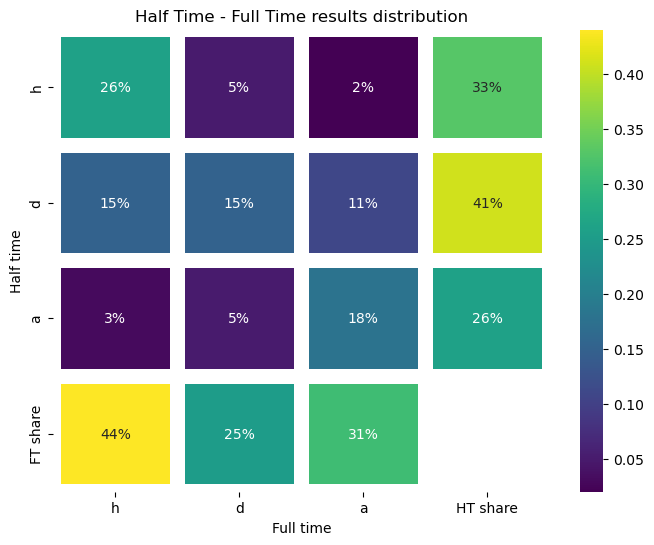

In [13]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pct, annot=True, fmt='.0%', cmap="viridis", linewidths=10)

plt.title('Half Time - Full Time results distribution')
plt.xlabel('Full time')
plt.ylabel('Half time')
plt.show()
plt.close()

### 1.3. Half and full time outcome - findings

- The heat map shows that 26% of the matches played ended in a home win both at half-time and after full time.
- At 18%, away wins are in second place.
- Just as many games ended in a draw - draw and a draw - home win.
- The rarest combination is a home win at half-time and an away win at full-time.
- In terms of the distribution of results at half-time, most matches ended in a home win (44%). In second place are victories by away teams (31%). The rarest result is a draw (25% of matches).
- To summarise, it can be said that the home venue has a slight influence on the results in injury time.
- Many games (41%) ended in a draw at half-time, meaning that 41% of games were decided in the second half.
- This can be due to many different factors, such as players' fitness and strength, as well as concentration waning during the game.
- Since the introduction of 5 substitutes in a game, changes in formation, the compactness of the team and the quality of the bench players can also be some of the reasons.

### 1.4. Half and full time outcome distribution by each league and season

Let's create the same heatmap for each season and each league to recognize patterns and league characteristics.

First, get lists of unique leagues and seasons in match dataset.

In [14]:
leagues = sorted(match_data.league.unique())
seasons = sorted(match_data.season.unique())

Define dimensions of subplot by number of leagues and number of seasons.

In [15]:
grid_dim = (len(seasons), len(leagues))

Create visualization of half and full time outcome distribution by each league and season.

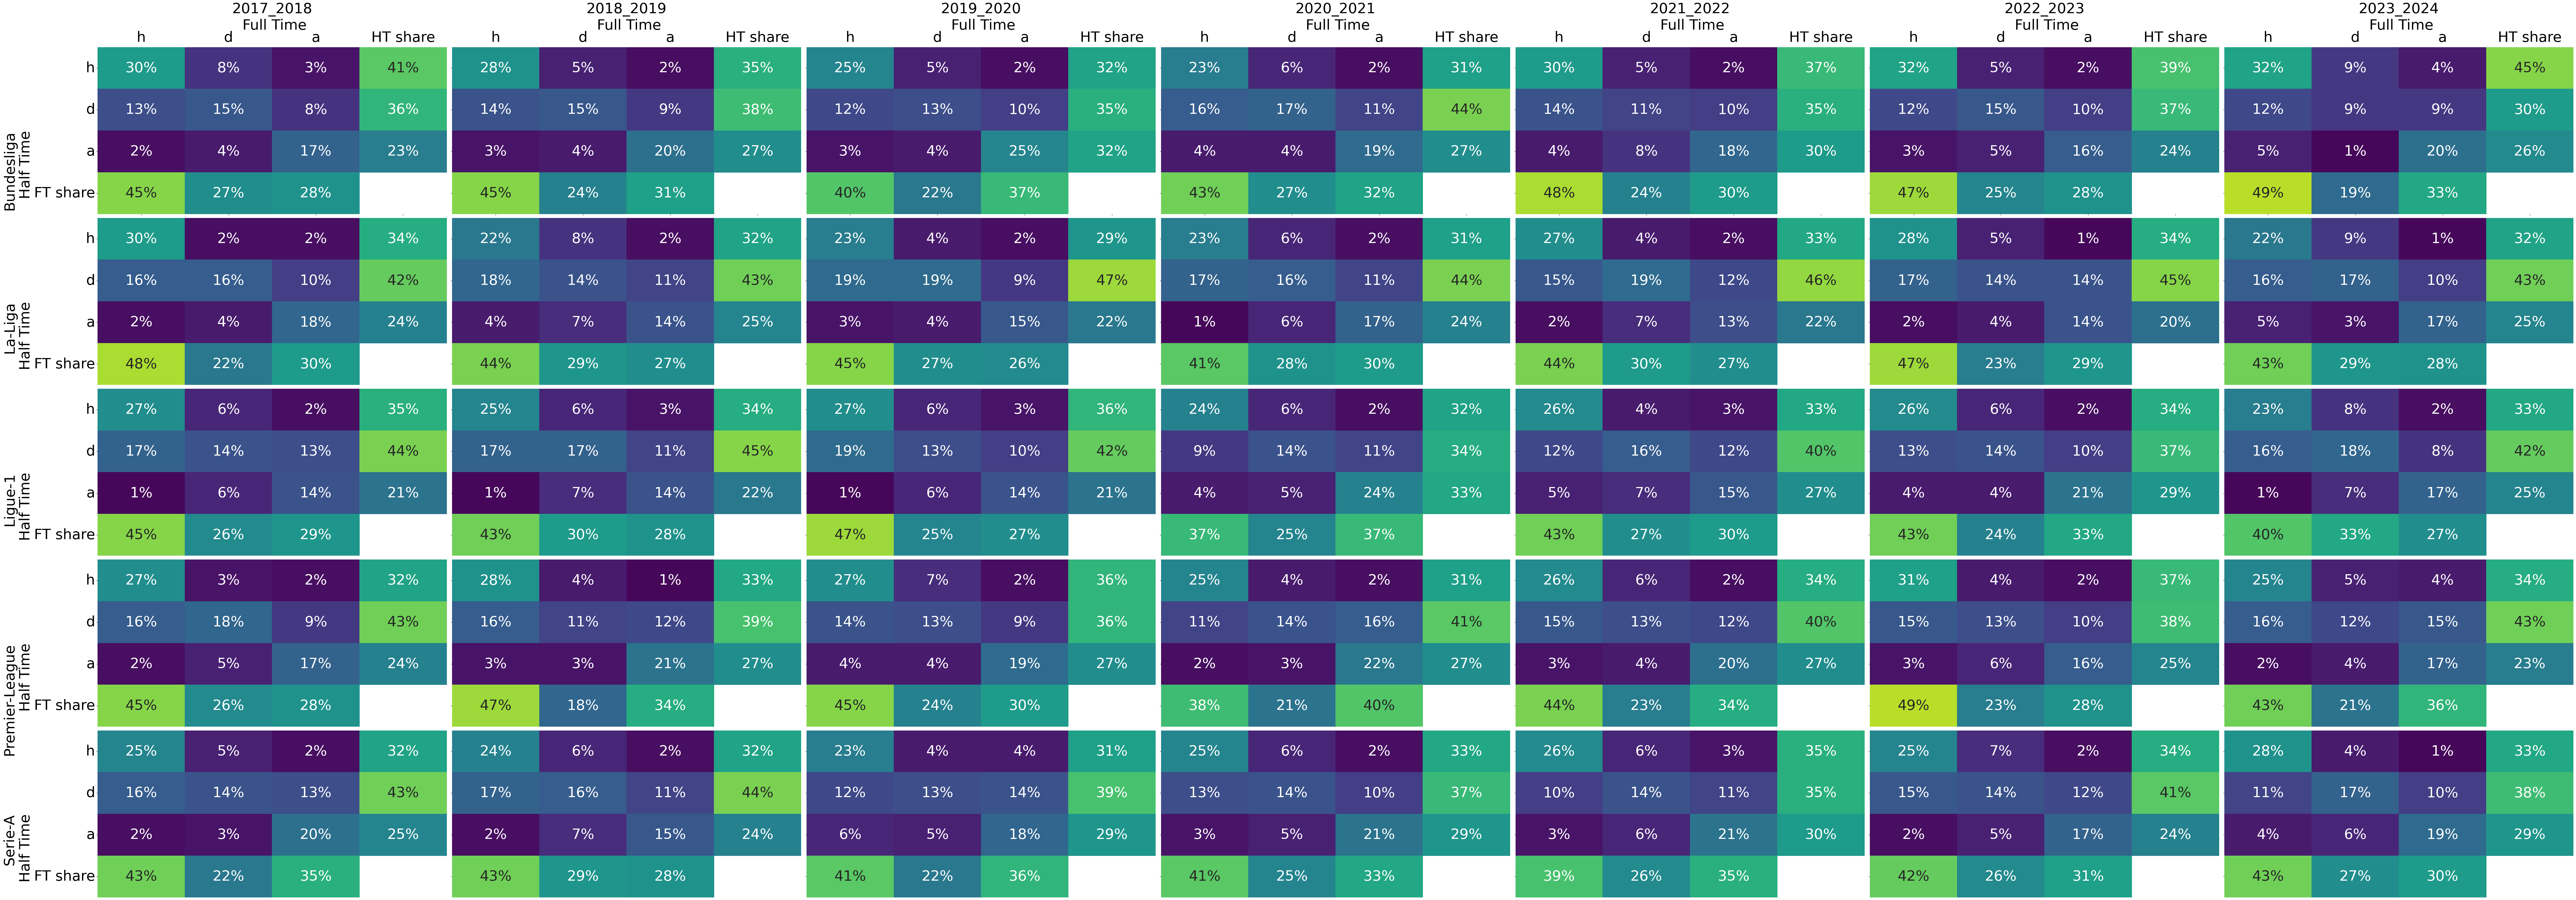

In [16]:
fig, axes = plt.subplots(grid_dim[1], grid_dim[0], figsize=(20*grid_dim[1], 5*grid_dim[0]),
                         sharex = True, sharey=True)

for i, s in enumerate(seasons):
    
    for j, l in enumerate(sorted(leagues)):

        df = match_data.loc[(match_data.season == s) & (match_data.league == l), ['hda_winner', 'ht_hda_winner']]
        
        cm = pd.crosstab(df['ht_hda_winner'], df['hda_winner']).sort_index(ascending = False, axis = 0).sort_index(ascending = False, axis = 1)
        
        cm = cm.div(cm.sum().sum())
        cm_pct = cm.round(2)
        
        cm_pct.loc['FT share',:] = cm_pct.sum()
        cm_pct.loc[:,'HT share'] = cm_pct.sum(axis = 1)
        cm_pct.at['FT share', 'HT share'] = None

        sns.heatmap(cm_pct, annot=True, fmt='0.0%', cmap='viridis', 
                            cbar=False, ax=axes[j, i], annot_kws={"size": 40}, 
                            vmin = 0, vmax=0.55)
        
        axes[0,i].set_xlabel(f'{s}\n Full Time', fontsize=40)
        axes[0,i].xaxis.set_label_position('top')
        axes[0,i].set_xticklabels(cm_pct.columns.values, fontsize = 40)
        axes[0,i].tick_params(axis='x', labeltop = True, labelsize=40) 
        
        axes[j,i].set_ylabel(f'{l}\n Half Time', fontsize=40, rotation = 90, ha='right')
        axes[j,i].set_yticklabels(cm_pct.index.unique(),fontsize=40, rotation = 0, ha = 'right')
        
        if j != 0:
            axes[j,i].set_xlabel('')
            axes[j,i].tick_params(axis='x',bottom=False,top=False,labelbottom=False)
        
        if i != 0:
            axes[j,i].set_ylabel('')
        
            
            
plt.tight_layout()
plt.show()
plt.close()
        

### 1.5. Half and full time outcome distribution by each league and season - findings

- In the chart above, the Bundesliga stands out as the league with the greatest home advantage, accounting for almost half of the matches in the last three seasons (48% - 47% - 49%)
- It is significant that the 2020-2021 season is the season with the lowest home-field effect.
- Ligue 1 and the Premier League are also well ahead with 37% and 38% home wins respectively. This is a drastic drop when looking at previous and subsequent seasons.
- Considering that the 2020-2021 season is characterised by the Covid restrictions, i.e. the drastic limitation of spectator numbers, this can be seen as the main cause of the decline in the home match rate.


## 2. Half and full time scored goals distribution by each league and season 

Given the above findings on the impact of Covid on the importance of the home ground, let us examine the impact of Covid (including the increasing number of substitutions) on the total number of goals scored.

In this section, we explore the next questions:
- What is the distribution of goals for each league per season?
- Is there a hidden pattern that can be identified in combination with the results from the previous section?

Let us calculate the half-time goals of the home and away team.

In [17]:
match_data['ht2_home_score'] = match_data.home_score - match_data.ht_home_score
match_data['ht2_away_score'] = match_data.away_score - match_data.ht_away_score

Visualize half and full time scored goals distribution by bar plot.

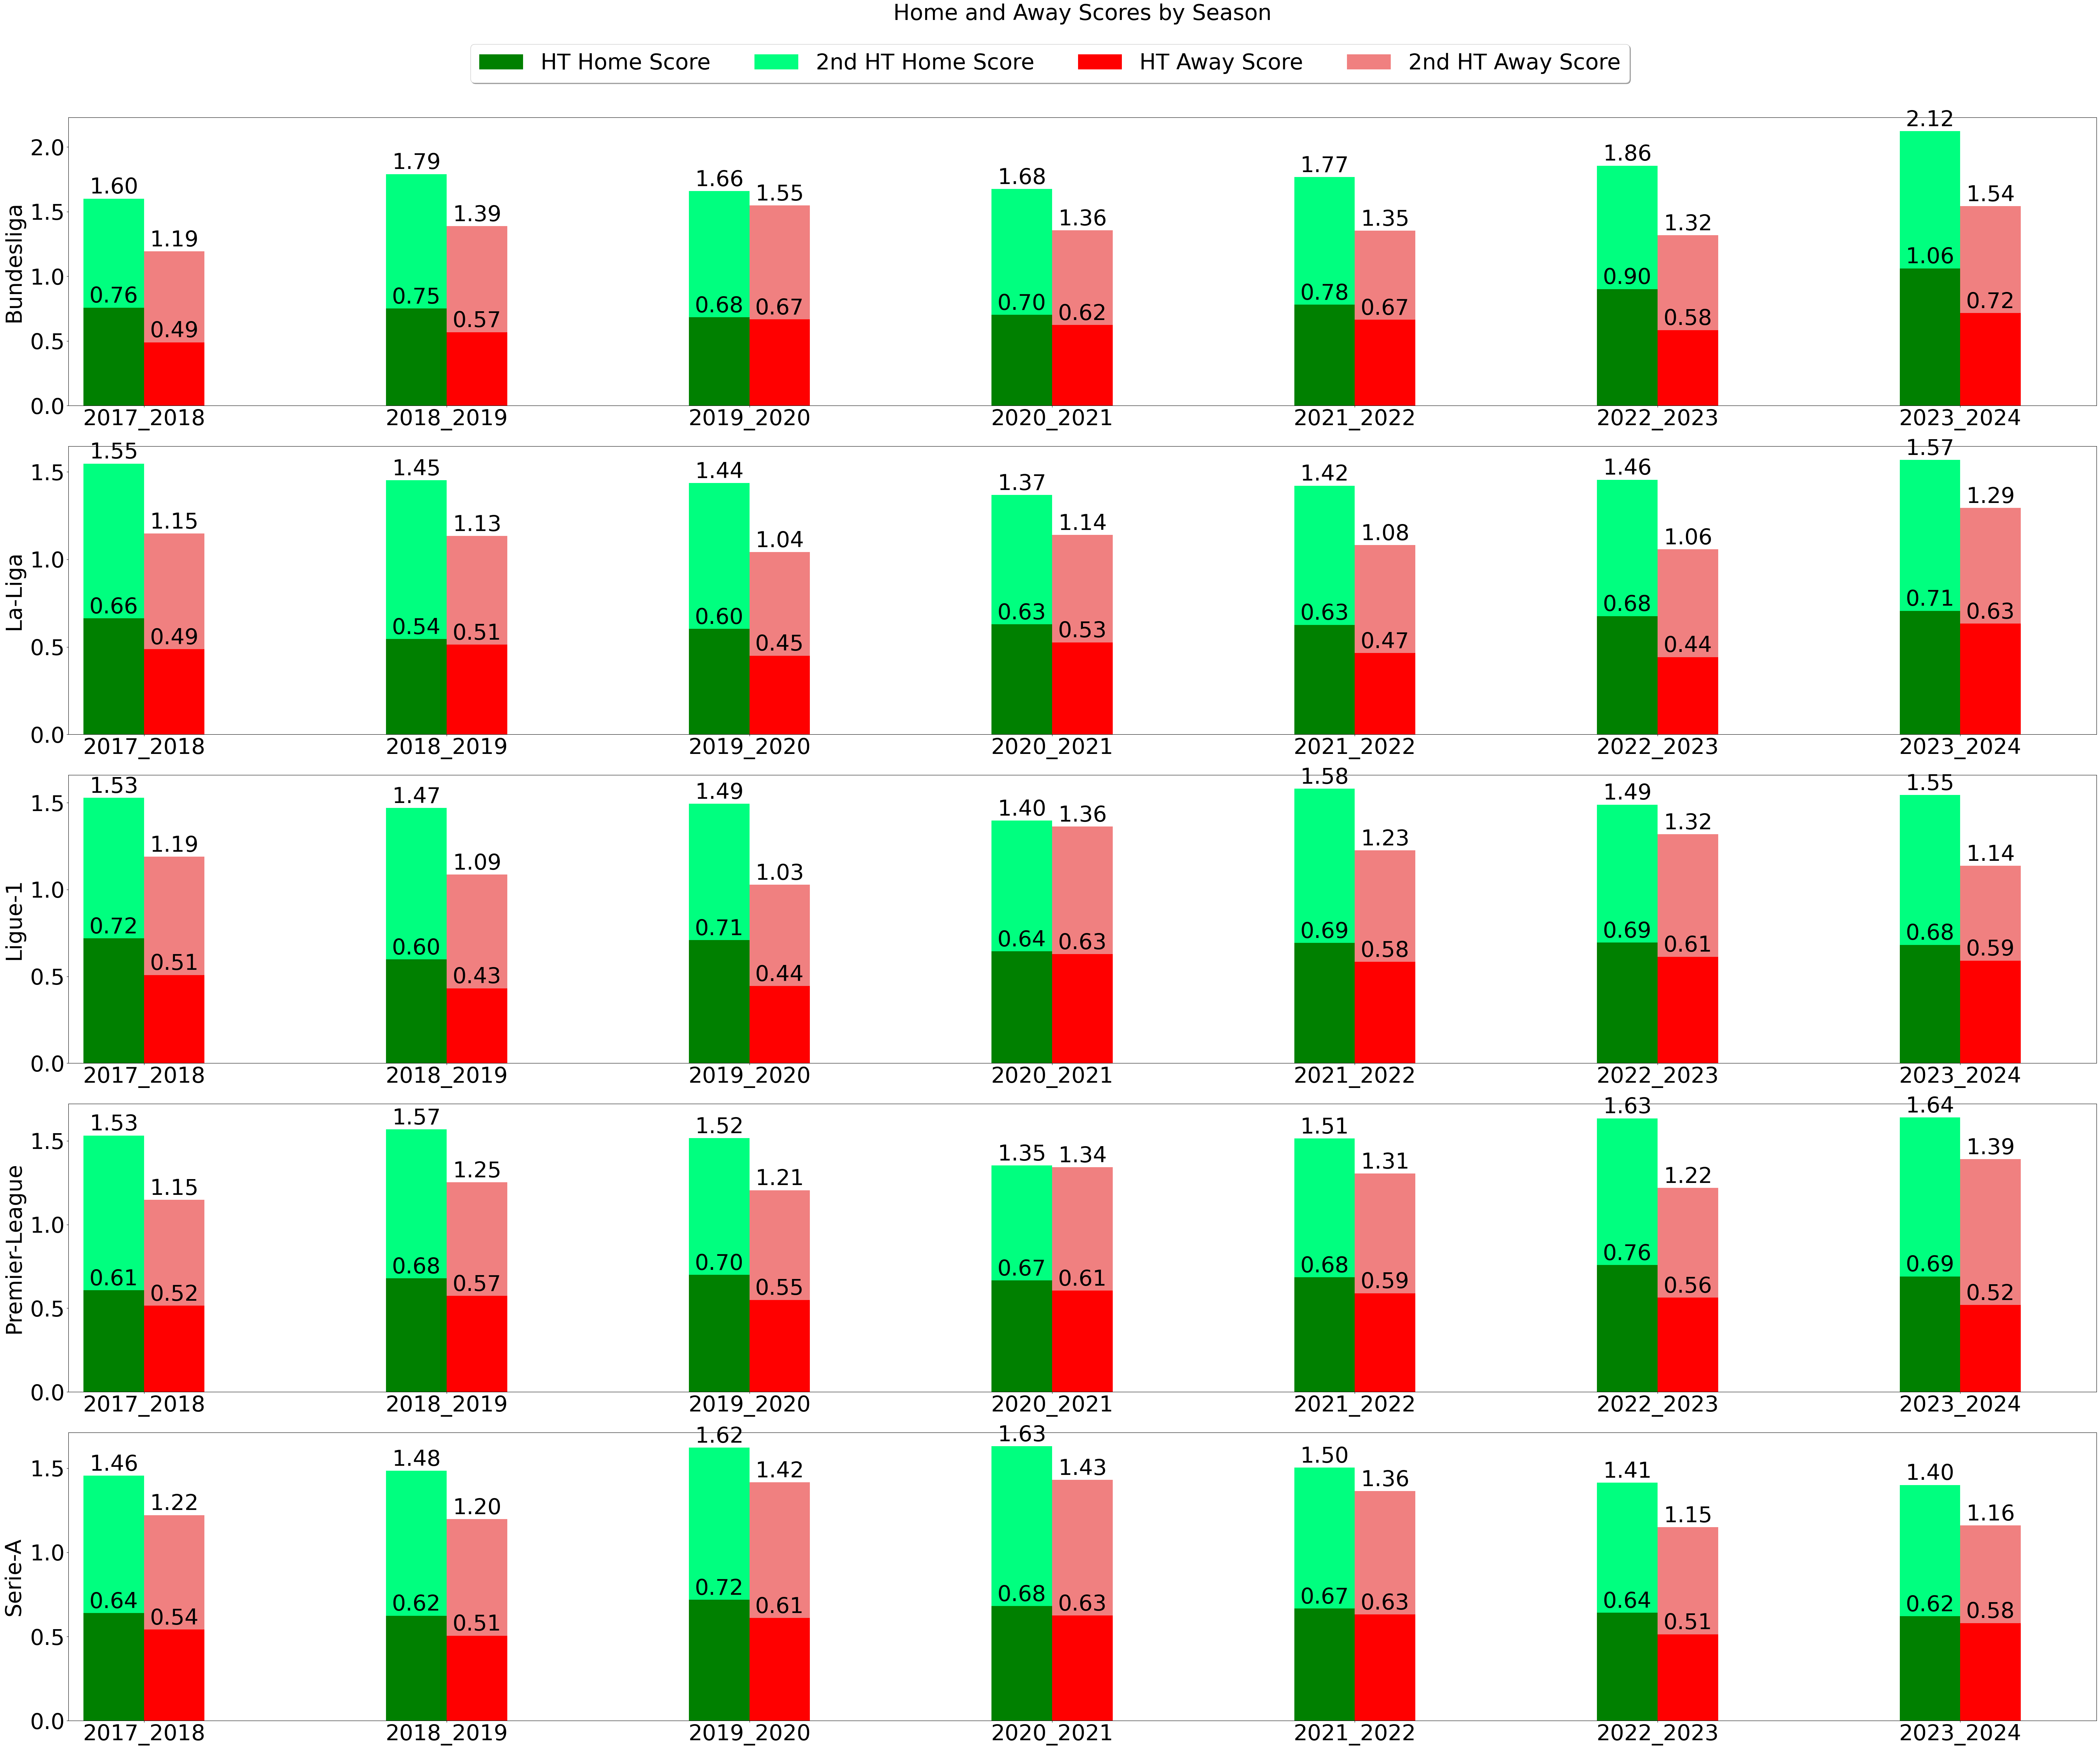

In [18]:
fig, axes = plt.subplots(grid_dim[1], 1, figsize=(60,50))

fs = 45
    
for j, l in enumerate(sorted(leagues)):
        
    axes[j].set_ylabel(f'{l}', rotation=90, labelpad=fs/4, fontsize=fs)
        
    df = match_data.loc[(match_data.league == l), ['season', 'home_score', 'ht_home_score', 'ht2_home_score',
                                                   'away_score', 'ht_away_score', 'ht2_away_score']]
    
    dfx = df.groupby('season').mean().reset_index()
    
    dfx[['ht_home_score', 'ht2_home_score']].plot(kind='bar', stacked=True, ax=axes[j],
                                                  position=0.5, width=0.2, 
                                                  colormap=LinearSegmentedColormap.from_list('home',['green', 'springgreen']))

    dfx[['ht_away_score', 'ht2_away_score']].plot(kind='bar', stacked=True, ax=axes[j],
                                                  position=-0.5, width=0.2, 
                                                  colormap=LinearSegmentedColormap.from_list('away',['red',  'lightcoral']))
    xtick_positions = [x + 0.1 for x in range(len(dfx.season.unique()))]
    axes[j].set_xticks(xtick_positions)
    xticklabels = sorted(dfx.season.unique())
    axes[j].set_xticklabels(xticklabels, fontsize = fs)
    axes[j].tick_params(axis='both', labelsize=fs, rotation = 0)

    
    if j == 0:
        axes[j].set_title('Home and Away Scores by Season', fontsize=fs, pad = 200)
    
    legend_labels = ['HT Home Score', '2nd HT Home Score', 'HT Away Score', '2nd HT Away Score']
    legend = axes[j].legend()
    legend.remove()
    
    for bar in axes[j].patches:

        axes[j].annotate(format(bar.get_y()+bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()+bar.get_y()), ha='center', va='center',
                   size=fs, xytext=(0,fs/2),
                   textcoords='offset points')
    
fig.legend(legend_labels, fontsize=fs, loc='upper center', bbox_to_anchor=(0.5, 0.98),
          fancybox=True, shadow=True, ncol=5)

plt.tight_layout()
plt.show()

### 2.1. Half and full time scored goals distribution by each league and season - findings
- The chart above confirms previous findings for the 2020-2021 season, where home and away goals are closer together than in the previous and following seasons.
- This is particularly evident in Ligue 1 and the Premier League, where home and away goals are almost equally distributed both at half-time and in regular time.
- In general, home teams have scored fewer goals in the 2020-2021 season than in other seasons.
- In the current season, the Bundesliga stands out as the league with the most goals for the home team, as it is the only league-season combination with 2+ goals per game for the home team.
- It is to be expected that this number will decrease as the number of matches increases, as this dataset only contains the first 10 matchweeks of the current season.

- In conclusion, we can see that Ligue 1 and Premier League teams are the most affected by the spectator restrictions caused by Covid.

## 3. The teams most affected by the attendance restrictions in the 2020-2021 season

In the previous section, attendance restrictions were recognised as a hidden factor that impacted results and targets in the 2020-2021 season. With this in mind, this section explores the next questions:
- Which teams were most affected by Covid restrictions?
- Which teams performed better without the support of the fans?

Firstly, let's create new columns showing whether the team played on a home or away pitch, which team won or drew the game and how many points the team scored in the game. The same applies to the results at full and half time.

In [19]:
player_match_data['place'] = player_match_data.apply(lambda row: 'home' if row.team==row.home_team else 'away', axis = 1)


player_match_data['team_winner'] = player_match_data.apply(lambda row: 
                                                           row.home_team if row.home_score>row.away_score else 
                                                           row.away_team if row.home_score<row.away_score else 
                                                           'draw', axis = 1)

player_match_data['ht_team_winner'] = player_match_data.apply(
    lambda row: row.home_team if row.ht_home_score>row.ht_away_score else 
    row.away_team if row.ht_home_score<row.ht_away_score else 'draw', 
                                                              axis = 1)

player_match_data['winner'] = player_match_data.apply(
    lambda row: 'w' if row.team==row.team_winner else 'd' if row.team_winner=='draw' else 'l', axis = 1)

player_match_data['ht_winner'] = player_match_data.apply(
    lambda row: 'w' if row.team==row.ht_team_winner else 'd' if row.ht_team_winner=='draw' else 'l', axis = 1)


player_match_data['win'] = (player_match_data['winner'] == 'w').astype(int)
player_match_data['lose'] = (player_match_data['winner'] == 'l').astype(int)

player_match_data['ht_win'] = (player_match_data['ht_winner'] == 'w').astype(int)
player_match_data['ht_lose'] = (player_match_data['ht_winner'] == 'l').astype(int)

player_match_data.drop('winner', inplace = True, axis = 1)
player_match_data.drop('ht_winner', inplace = True, axis = 1)

player_match_data['points'] = player_match_data.apply(
    lambda row: 3 if row.win==1 else 0 if row.lose==1 else 1, axis = 1)

player_match_data['ht_points'] = player_match_data.apply(
    lambda row: 3 if row.ht_win==1 else 0 if row.ht_lose==1 else 1, axis = 1)


Define columns which are unique for each team in each match (2 rows for each match: 1 for home team and 1 for away team).

In [20]:
team_season_cols = ['league', 'season','team', 'place']

Group dataset by defined list of columns to generate dataset with 2 rows for each match: 1 for home team and 1 for away team.

In [21]:
numeric_columns = player_match_data.select_dtypes(include=[np.number]).columns.tolist()
redundant_numeric_columns = ['dayofweek', 'home_xg',
       'away_xg', 'gameweek', 'x', 'y',
       'shirtnumber', 'minutes']
numeric_columns = [col for col in numeric_columns if col not in redundant_numeric_columns]

pct_cols = [x for x in player_match_data.columns if '_pct' in x]

mean_cols = pct_cols.copy()
mean_cols.append('age')
mean_cols.append('attendance')
mean_cols.append('points')
mean_cols.append('ht_points')

agg_dict = {col: 'sum' for col in numeric_columns if col not in mean_cols and col not in team_season_cols}

for x in mean_cols:
    agg_dict[x]='mean'

team_season_place = player_match_data.groupby(team_season_cols).agg(agg_dict).reset_index()

For each team in each season create column 'league_rank' with team position on league table for home matches as well as for away matches.

In [22]:
leagues = player_match_data.league.unique()
seasons = player_match_data.season.unique()

team_season_place.sort_values('points', ascending=False, inplace=True)

for l in leagues:
    for s in seasons:
        for p in team_season_place.place.unique():
            maskx = (team_season_place.league == l) & (team_season_place.season == s) & (team_season_place.place == p)
            team_season_place.loc[maskx, 'league_rank'] = range(1, len(team_season_place[maskx]) + 1)



Filter only home matches stats for each team due to analyze of covid restrictions impact on home ground match outcomes.

In [23]:
team_season_home = team_season_place.loc[team_season_place.place=='home']
team_season_home.sort_values('season', inplace = True)

For each team calculate points difference between consecutive seasons.

In [24]:
for team in team_season_home.team.unique():
    tempdf = team_season_home.loc[team_season_home.team==team]
    
    pts_diff = (tempdf.points-tempdf.points.shift()).values
    
    team_season_home.loc[team_season_home.team==team, 'point_difference'] = pts_diff
    

Sort teams by point difference from teams with larges points drop between 2 consecutive seasons.
Filter all seasons except current season which is not finished yet.

In [25]:
team_season_home = team_season_home.sort_values('point_difference')
team_season_home = team_season_home.loc[team_season_home.season!='2023_2024']

Filter ordered team names by teams whic had largest points drop in season 2020-2021.

In [26]:
worst21= team_season_home.loc[team_season_home.season=='2020_2021'].sort_values('point_difference').team.values

Filter teams which appeared in more than 1 season.

In [27]:
n_seasons = team_season_home.groupby('team').count().reset_index()
teams_seasons = n_seasons.loc[n_seasons.league>=2].team.values
worst21 = [x for x in worst21 if x in teams_seasons]

Filter rows in dataset with teams that appeared in more than 1 season.

In [28]:
worst_df = team_season_home.loc[team_season_home.team.isin(worst21)]

Visualize line chart with points per game value for each season from 2017-2018 till 2022-2023. Charts are ordered from team with largest points drop in Covid season to teams which increased points per game in the same season.

In [ ]:
seasons = ['2017_2018', '2018_2019', '2019_2020', '2020_2021', '2021_2022', '2022_2023']

ncols = 5
nrows  =int(np.ceil(len(worst21)/ncols))

fig, axes = plt.subplots(nrows,ncols, figsize=(80,200), dpi = 200, sharex=True, sharey=True)
k = 0
fs = 60
for i in range(0,nrows):
    axes[i,0].set_ylabel('Points per game', rotation=90, labelpad=fs/4, fontsize=fs*0.8)
    for j in range(0,ncols):
        
        if k<len(worst21):
        
            team_data = worst_df.loc[worst_df.team==worst21[k]]
        
            ses = team_data.season.unique()
        
            empty_seasons = [x for x in seasons if x not in ses]
        
            if len(empty_seasons)!=0:
                for es in empty_seasons:
                    team_data.loc[len(team_data), ['season', 'points']] = [es,None]
        
            team_data = team_data.sort_values('season')    

            # Plot the line chart
            axes[i,j].plot(team_data['season'].tolist(), team_data['points'].tolist(), label=team, marker='o', linewidth=10)  
            axes[i,j].plot([3,3], [0,3], label=team, linewidth=1, c='k')  
            axes[i,j].set_xticks(axes[i,j].get_xticks())
            axes[i,j].set_xticklabels(seasons, fontsize=fs, rotation=90)
            axes[i,j].set_title(f'{worst21[k]}', fontsize=fs)
            axes[i,j].tick_params('both',labelsize = fs)     

            # Add legend
            legend = axes[i,j].legend()
            legend.remove()
        
            k+=1

# Show the plot
plt.show()
plt.close()

### 3.1. The teams most affected by the attendance restrictions in the 2020-2021 season - findings
The above chart is complex, but here are the main results:
- Teams such as Dijon, Sheffield Utd, Parma, Schalke 04, Nimes, Valladolid, etc. had significant point losses in the Covid season that led to relegation. In general, the teams whose lines break in the 2020-2021 season are those who were relegated in the same season. There are many factors that can be decisive for a team's relegation. In the 2020-2021 season, one of them is the limited number of spectators, which can be an important factor.
- Teams such as Liverpool, Strasbourg, Angers, Nice, Nantes, Paris S-G, Leicester, Koln, Arsenal, Hellas Verona etc. have a 'V' shaped line which indicates that the teams have fewer points per game only in the Covid season. This indicates that there is an increased likelihood that the loss of points is due to playing in front of empty stands. In every other season they have done much better.
- Teams such as Montpellier, Barcelona, M'Gladbach, Reims, Burnley, Valencia, etc. have scored significantly fewer points in the 2020-2021 season, but have performed similarly or even worse in subsequent seasons. This suggests that the loss of points is likely caused by more factors than just crowd restrictions.
- Teams like Fulham, Crotone etc. have performed in single seasons that are not consecutive. Therefore, their drop in points is not reliable.
- Teams like Wolfsburg, Inter, RB Leipzig, Roma, Eint Frankfurt, West Ham etc. performed significantly better in front of empty home stadiums than in seasons without crowd restrictions.
- Teams such as Lorient, Spezia, Arminia, etc. were promoted to the first division in the 2020-2021 season and can therefore not be included in this analysis.
- Teams that performed better without fans may be candidates for teams that have problems dealing with the pressure of home games.
- In general, the teams without fans performed worse, i.e. the teams have significant support from the fans.

## 4. Conclusion

This analysis led to the following key findings
- The advantage of home games has decreased in the 2020-2021 season, due to restricted attendance due to Covid.
- The most affected leagues were Ligue 1 and the Premier League, where the percentage of home team wins dropped dramatically compared to the previous and following season.
- The above results are confirmed by analysing the goals scored by home and away teams, which were almost equal in the 2020-2021 season in Ligue 1 and the Premier League. The same ratio is significantly greater in favour of home teams in other seasons.
- The line graph of points per game scored by teams over the last 6 seasons shows that teams with V-shaped lines are likely to perform worse due to empty home stands. Such teams are Liverpool, Strasbourg, Angers, Nice, Nantes, Paris S-G, Leicester, Koln, Arsenal, Hellas Verona, etc.
- On the other hand, several teams have done better in the same season. These teams can be candidates for teams that have problems dealing with the pressure of playing in front of their own fans.

Thank you for your attention! If you find this analysis interesting, please feel free to comment and share it.

You are also welcome to contact me if you have any suggestions for future analyses.

email: ivanbrkic@gmail.com
